In [1]:
import pandas as pd
import numpy as np

In [71]:
import matplotlib as plt
%matplotlib inline

In [3]:
import ipywidgets as widgets

In [39]:
import Basic_Risk_Assessment_Tools as brat

In [5]:
%load_ext autoreload
%autoreload 2

# Random Walk Generation

Recall that the stochastic model for asset returns is given by the Geometric Brownian Motion process:

$$ \frac{S_{t+dt}-S_t}{S_t} = \mu dt + \sigma\sqrt{dt}\xi_t $$

In [7]:
def geo_brown_motion(n_years=10, n_scenarios=10000, mu=0.07, sigma=0.15, steps_per_year=260, initial_price=100):
    """
    Evolution of Geometric Brownian Motion trajectories, such as for Stock Prices
    :param n_years:  The number of years to generate data for
    :param n_paths: The number of scenarios/trajectories
    :param mu: Annualized Drift, e.g. Market Return
    :param sigma: Annualized Volatility
    :param steps_per_year: granularity of the simulation
    :param initial_price: initial value of asset
    
    Xi is Random Normally Distributed Number.
    
    :return: a numpy array of n_paths columns and n_years*steps_per_year rows
    """
    dt = 1/steps_per_year
    n_steps = int(n_years*steps_per_year)
    returns_plus_1 = np.random.normal(loc=1+mu*dt, scale=sigma*np.sqrt(dt), size=(n_steps, n_scenarios))
    returns_plus_1[0] = 1
    # returns to prices
    prices = initial_price*pd.DataFrame(returns_plus_1).cumprod()
    return prices

In [8]:
simulated_prices = geo_brown_motion(n_years=10, n_scenarios=10, mu=0.07)
simulated_prices

,0,1,2,3,4,5,6,7,8,9
0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,99.283644,100.798767,103.058699,99.470376,100.142921,101.022464,99.644655,98.743829,98.408518,101.345820
2,99.471897,101.101281,101.459108,100.549227,99.781939,101.547799,97.864532,99.548569,96.777874,101.673929
3,99.677957,101.395161,102.131234,99.611137,99.590028,101.659368,97.917572,100.675378,97.263849,100.405029
4,100.010195,102.613179,102.053884,98.592466,99.275417,100.994991,97.201262,103.010157,95.163973,98.624544
...,...,...,...,...,...,...,...,...,...,...
2595,264.725051,321.405513,175.593547,312.325229,162.799177,170.402491,231.602755,243.755188,157.301665,77.744354
2596,267.743887,323.254284,175.334385,311.262111,162.126110,170.020221,231.639840,243.902277,161.005817,77.440489
2597,265.959215,325.341593,177.371912,313.148234,162.696622,171.711920,229.842484,248.147717,161.663599,77.601207
2598,266.958541,323.813463,178.864035,311.382789,164.052813,175.419014,229.380780,249.915842,162.520211,77.513217


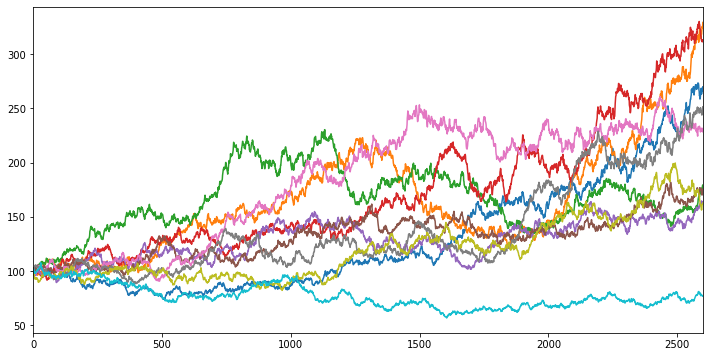

In [9]:
simulated_prices.plot(legend=False, figsize=(12, 6))

TESTING IPYWIDGETS

In [10]:
def squareit(number):
    return number*number

In [11]:
squareit(5)

25

In [12]:
widgets.interact(squareit, number=(0,100))

interactive(children=(IntSlider(value=50, description='number'), Output()), _dom_classes=('widget-interact',))

<function __main__.squareit(number)>

# Interactive plotting of Geometric Random Walk

In [32]:
def show_gbm(n_scenarios, mu, sigma, n_years=10, initial_price=100):
    """
    Draw the results of a stock price evolution under a Geometric Brownian Motion model
    """
    prices = brat.geo_brown_motion(n_scenarios=n_scenarios, mu=mu, sigma=sigma, initial_price=initial_price)
    ax = prices.plot(legend=False, color="indianred", alpha = 0.5, linewidth=2, figsize=(12,5))
    ax.axhline(y=100, ls=":", color="black")
    # draw a dot at the origin
    ax.plot(0,initial_price, marker='o',color='darkred', alpha=0.2)

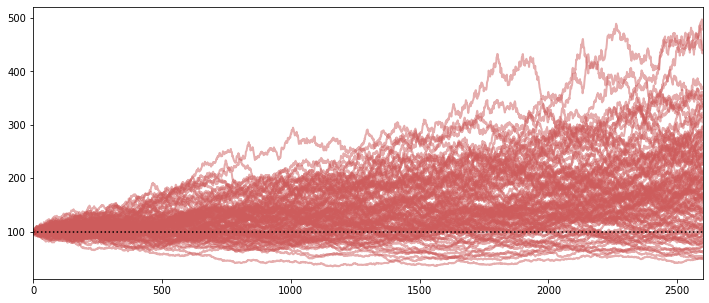

In [33]:
show_gbm(n_scenarios=100, mu=0.07, sigma=0.15)

In [15]:
gbm_controls = widgets.interactive(show_gbm,
                   n_scenarios = (1,20,1),
                   mu = (-0.2,0.2,0.01),
                   sigma = (0,0.3,0.01),
                    initial_price = (100,500,100)
                   )

In [16]:
display(gbm_controls)

interactive(children=(IntSlider(value=10, description='n_scenarios', max=20, min=1), FloatSlider(value=0.0, de…

BEHAVIOUR OF SIMULATION WRT PARAMETERS

MU:

If we slide MU to a negative value then the scenarios tend to 'drift' towards values lesser than the initial price invested. Similarly, when the MU is given a positive value the returns drift to a value greater than the initial investment.

This is why the MU value is also known as the DRIFT OF THE ASSET RETURN.

SIGMA:

It affects the spread of the returns around the mean. Thus, by increasing the value of SIGMA we find that the returns spread over a larger region (0-1200 for SIGMA=0.27) because of a greater volatility in the market simulation.

Conversely, when we decrease sigma the scenarios tend to get squeezed together until at SIGMA=0 we get a single line which moves up (if MU is positive) or down (if MU is negative).

# Interactive CPPI Simulation

In [92]:
def show_simulated_cppi(n_years, n_scenarios, mu, sigma, m, floor, risk_free_return, y_max):
    """
    Plot the results of a Monte Carlo Simulation of CPPI
    """
    start = 100
    simulated_prices = brat.geo_brown_motion(n_years=n_years, n_scenarios=n_scenarios, mu=mu, sigma=sigma, steps_per_year=260, initial_price=start)
    simulated_returns_dict = {}
    for header in list(simulated_prices.columns):
        simulated_returns_dict[header] = pd.DataFrame(simulated_prices[header].pct_change().drop(0))

    # run the cppi on the simulated returns
    btr = brat.cppi(simulated_returns_dict, risk_free_return=risk_free_return, m=m, start=start, floor=floor)
    wealth = btr["Wealth"]      #Dataframe of value of investment through time
    y_max=wealth.values.max()*y_max/100     #used to zoom into plot
    terminal_wealth = wealth.iloc[-1]        #Final value of investment
    
    tw_mean = terminal_wealth.mean()        #mean of terminal wealth across scenarios
    tw_median = terminal_wealth.median()    #median of terminal wealth across scenarios
    failure_mask = np.less(terminal_wealth, start*floor)    #gives boolean mask for when terminal wealth is below floor across scenarios
    n_failures = failure_mask.sum()         #adds the TRUE/1 values in boolean mask to give count of breaches
    p_fail = n_failures/n_scenarios         #percentage of failures
    
    # calculate the loss  when terminal wealth is less than floor
    e_shortfall = np.dot(terminal_wealth-start*floor, failure_mask)/n_failures if n_failures > 0 else 0.0
    
    # Plotting
    # Plot histogram of final investment value for the various scenarios
    fig, (wealth_ax, hist_ax) = plt.pyplot.subplots(nrows=1, ncols=2, sharey=True, gridspec_kw={'width_ratios':[3,2]}, figsize=(24, 9))
    plt.pyplot.subplots_adjust(wspace=0.0)    #reduce space between both plots to zero
    
    ax = wealth.plot(legend=False, alpha=0.3, color="indianred", figsize=(24,9))
    ax.axhline(y=start, ls=":", color="black")      #plot the initial investment as a line
    ax.axhline(y=start*floor, ls="--", color="red") #plot floor value as a line
    ax.set_ylim(top=y_max)
    
    terminal_wealth.plot.hist(ax=hist_ax, bins=50, ec='w', fc='indianred', orientation='horizontal')
    hist_ax.axhline(y=start, ls=":", color="black")
    hist_ax.axhline(y=start*floor, ls=":", color="blue")
    hist_ax.axhline(y=tw_mean, ls=":", color="green")
    hist_ax.axhline(y=tw_median, ls=":", color="purple")
    hist_ax.annotate(f"Mean: ${int(tw_mean)}", xy=(.7, .9),xycoords='axes fraction', fontsize=24)
    hist_ax.annotate(f"Median: ${int(tw_median)}", xy=(.7, .85),xycoords='axes fraction', fontsize=24)
    if (floor > 0.01):
        hist_ax.axhline(y=start*floor, ls="--", color="red", linewidth=3)
        hist_ax.annotate(f"Violations: {n_failures} ({p_fail*100:2.2f}%)\nE(shortfall)=${e_shortfall:2.2f}", xy=(.7, .7), xycoords='axes fraction', fontsize=24)

In [95]:
cppi_controls = widgets.interactive(show_simulated_cppi,
                                    n_years=(0,20,1),
                                    n_scenarios=widgets.IntSlider(min=1, max=505, step=5, value=50),
                                    mu=(0., +.2, .01),
                                    sigma=(0, .30, .05),
                                    m=(1, 5, .5),
                                    floor=(0, 2, .1),
                                    risk_free_return=(0, .05, .01),
                                    y_max=widgets.IntSlider(min=0, max=100, step=1, value=100, description="Zoom Y Axis")
                                   )

In [96]:
display(cppi_controls)

interactive(children=(IntSlider(value=10, description='n_years', max=20), IntSlider(value=50, description='n_s…

For 96 scenarios, we find that even in a highly volatile market with SIGMA=0.25 the CPPI Portfolio never finished below the floor which shows a sound investment strategy.

If we raise the volatility beyond normal levels to values greater than 0.3, as the volatility increases the number of violations also increase. The Expected Shortfall also becomes larger as our investment strategy becomes more courageous (M is increased) However these are really unlikely, and maybe even unrealistic, scenarios and CPPI works as very efficient strategy in markets resembling the real market conditions

Feel free to play with the controls to see how the CPPI model performs as the parameters are varied.

NOTE: The charts take some time to refresh on my system so please be cognizant of your system capabilities, which I am sure are better than mine :D